In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import geopy.distance
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', None)


In [2]:
credit_df = pd.read_csv('credit_card_transactions.csv')

In [3]:
credit_df.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0


# EDA

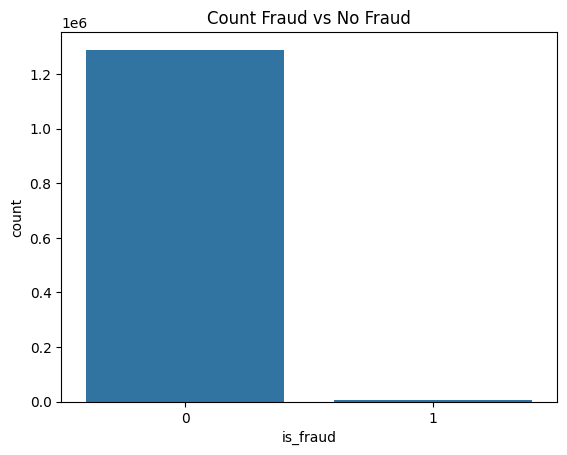

In [4]:
sns.countplot(x='is_fraud', data=credit_df)
plt.title('Count Fraud vs No Fraud')
plt.show()

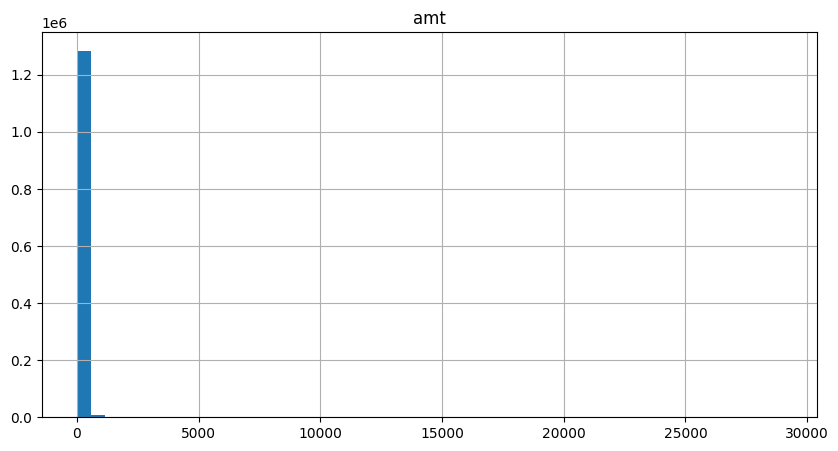

In [5]:
credit_df[['amt']].hist(bins=50, figsize=(10,5))
plt.show()

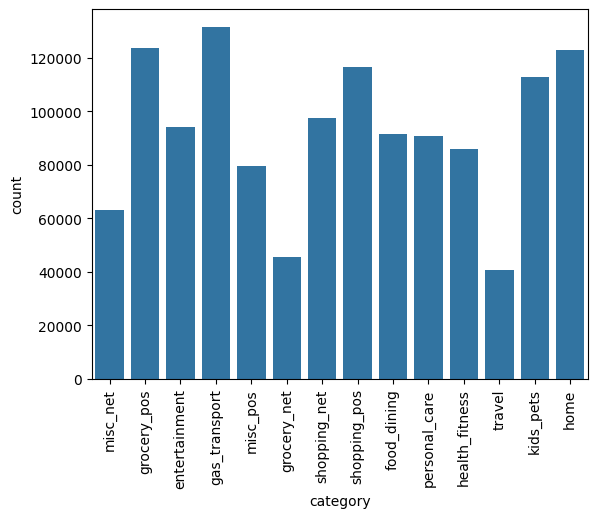

In [6]:
sns.countplot(x='category', data=credit_df).\
tick_params(axis='x', labelrotation=90)

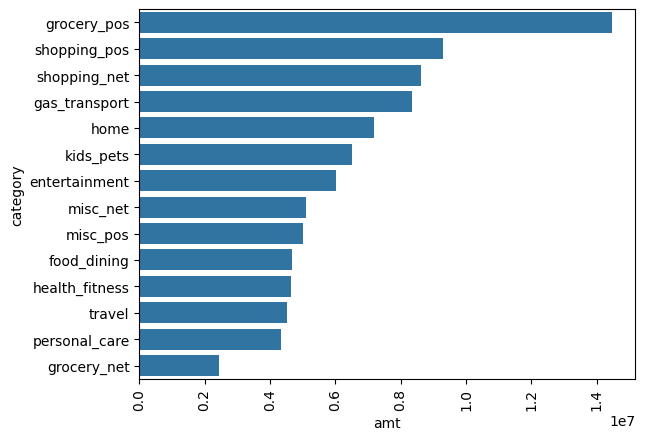

In [7]:
df = credit_df.groupby('category')['amt'].sum().reset_index().sort_values('amt', ascending=False)
sns.barplot(x='amt', y='category', data=df).\
tick_params(axis='x', labelrotation=90)

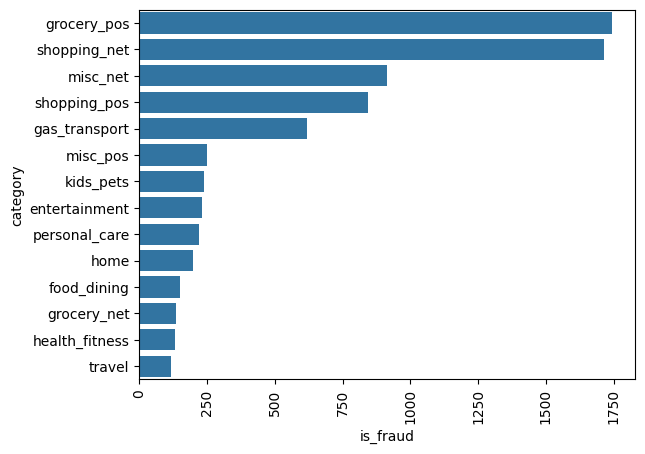

In [8]:
df = credit_df.groupby('category')['is_fraud'].sum().reset_index().sort_values('is_fraud', ascending=False)
sns.barplot(x='is_fraud', y='category', data=df).\
tick_params(axis='x', labelrotation=90)

It seems that the category has a strong correlation with fraud, maybe one hot enconded should be applyed in this column

<Axes: xlabel='is_fraud', ylabel='state'>

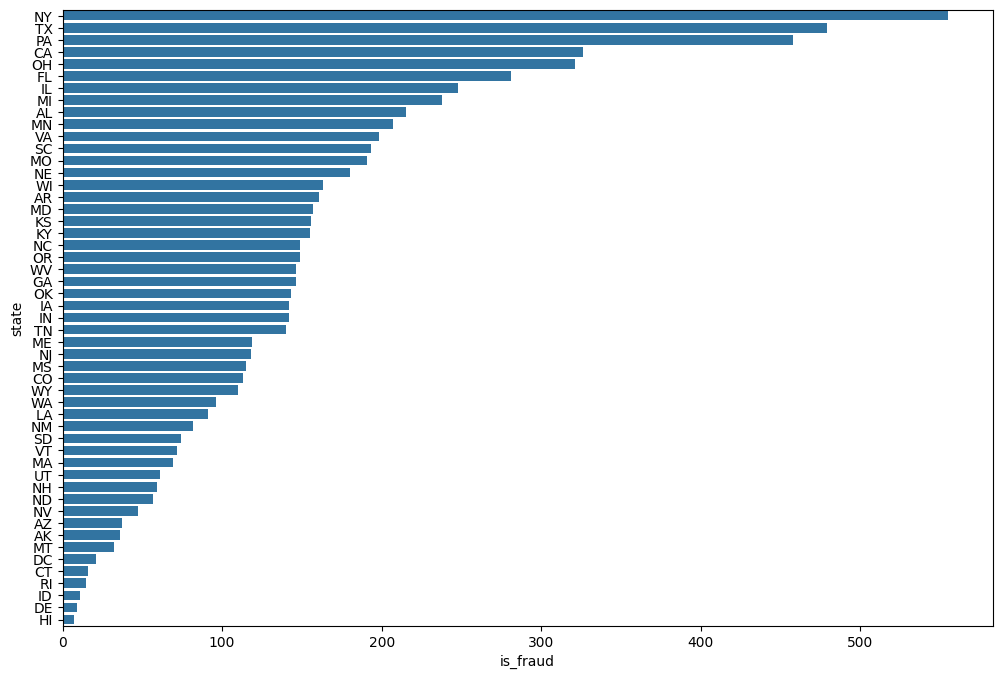

In [9]:
df = credit_df.groupby('state')['is_fraud'].sum().reset_index().sort_values('is_fraud', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='is_fraud', y='state', data=df)

The state also seems to have a strong correlation, but it's probably due to the population, states with larger populations tend to have more fraud cases.

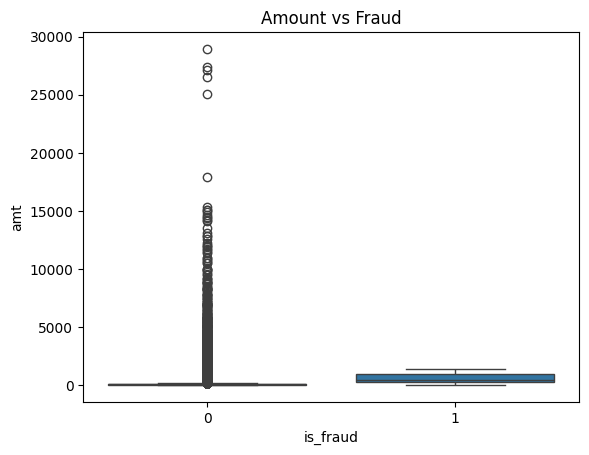

In [10]:
sns.boxplot(x='is_fraud', y='amt', data=credit_df)
plt.title('Amount vs Fraud')
plt.show()

# Feature Engineering

First of all, we will create a new column that is the calcule betwenn lat / lon of the merchant vs lat / lon of the customer
In a second moment I could calculate how munch transactions the customer has on this merchant
and I can see if the date/time of the buy is in a point that sounds suspect (maybe build a time column)

## Column Distance

In [11]:
credit_df['coords'] = credit_df.apply(lambda row: f"{row['lat']},{row['long']}", axis = 1)
credit_df['merch_coords'] = credit_df.apply(lambda row: f"{row['merch_lat']},{row['merch_long']}", axis = 1)

In [12]:
credit_df['distance'] = credit_df.apply(lambda row: geopy.distance.geodesic(row['coords'], row['merch_coords']).km, axis=1)

In [13]:
credit_df[['coords','merch_coords','distance']]

,coords,merch_coords,distance
0,"36.0788,-81.1781","36.011293,-82.048315",78.773821
1,"48.8878,-118.2105","49.159047,-118.186462",30.216618
2,"42.1808,-112.262","43.150704,-112.154481",108.102912
3,"46.2306,-112.1138","47.034331,-112.561071",95.685115
4,"38.4207,-79.4629","38.674999,-78.632459",77.702395
...,...,...,...
1296670,"37.7175,-112.4777","36.841266,-111.69076499999998",119.696415
1296671,"39.2667,-77.5101","38.906881,-78.246528",75.202184
1296672,"32.9396,-105.8189","33.619513,-105.130529",98.987927
1296673,"43.3526,-102.5411","42.78894,-103.24116",84.688356


## Gender Column Binarization

In [14]:
credit_df['gender'] = credit_df['gender'].map({'M': 1, 'F': 0})

## Frequency

In [15]:
credit_df['frequency'] = credit_df.groupby(['merchant', 'cc_num'])['trans_num'].transform('count')


## Age

In [16]:
today = datetime.today()

credit_df['age'] = pd.to_datetime(credit_df['dob']).apply(lambda dob: today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day)))

## Purchase Time

In [17]:
credit_df['purchase_time'] = pd.to_datetime(credit_df['trans_date_trans_time']).dt.strftime('%H:%M')

In [18]:
credit_df['purchase_time'] = pd.to_datetime(credit_df['purchase_time'], format='%H:%M')
credit_df['purchase_time'] = credit_df['purchase_time'].dt.hour * 60 + credit_df['purchase_time'].dt.minute

Because I'll be applying standard scaling later, the time format can't remain in HH:MM, so I had to convert it to just minutes.

## Category One Hot Encoding

Previosly we saw that the Category Column has a great correlation with is_fraud so we will apply one hot encoding in that column

In [19]:
credit_df['category']

0               misc_net
1            grocery_pos
2          entertainment
3          gas_transport
4               misc_pos
               ...      
1296670    entertainment
1296671      food_dining
1296672      food_dining
1296673      food_dining
1296674      food_dining
Name: category, Length: 1296675, dtype: object

In [20]:
enconder = OneHotEncoder(sparse_output=False)
encoded_data = enconder.fit_transform(credit_df[['category']])
encoded_category = pd.DataFrame(encoded_data, columns=enconder.get_feature_names_out(['category'])).astype(int)
credit_df = pd.concat([credit_df, encoded_category], axis = 1)


In [21]:
credit_df_transformed = credit_df[['purchase_time','amt', 'gender', 
           'city_pop', 'age', 
           'distance', 
           'frequency','category_entertainment', 'category_food_dining', 
           'category_gas_transport', 'category_grocery_net', 
           'category_grocery_pos', 'category_health_fitness', 'category_home', 
           'category_kids_pets', 'category_misc_net', 
           'category_misc_pos', 'category_personal_care', 
           'category_shopping_net', 'category_shopping_pos', 
           'category_travel', 'is_fraud']]

credit_df_transformed.sample(1)

,purchase_time,amt,gender,city_pop,age,distance,frequency,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,is_fraud
845460,1134,9.15,0,165556,26,74.285368,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Saving the Data Transformed

In [22]:
credit_df_transformed.to_csv('credit_df_transformed.csv')

## StandartScale

Because some columns are in different scales, such as thousands, tens, or units, we need to apply scaling.

In [2]:
credit_df_transformed = pd.read_csv('credit_df_transformed.csv')

In [3]:
scaler = StandardScaler()

In [4]:
cols_to_scale = ['purchase_time', 'amt', 'city_pop', 'age', 'distance', 'frequency']

credit_df_transformed.loc[:, cols_to_scale] = credit_df_transformed[cols_to_scale].astype(float)


credit_df_transformed.loc[:, cols_to_scale] = scaler.fit_transform(credit_df_transformed[cols_to_scale])


C:\Users\User\AppData\Local\Temp\ipykernel_9816\255359978.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.9485538  -1.9485538  -1.9485538  ... -0.16068082 -0.15823837
 -0.15823837]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  credit_df_transformed.loc[:, cols_to_scale] = scaler.fit_transform(credit_df_transformed[cols_to_scale])
C:\Users\User\AppData\Local\Temp\ipykernel_9816\255359978.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.28258876 -0.29366984 -0.28040632 ... -0.29118603 -0.29043427
 -0.29344133]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  credit_df_transformed.loc[:, cols_to_scale] = scaler.fit_transform(credit_df_transformed[cols_to_scale])
C:\Users\User\AppData\Local\Temp\ipykernel_9816\255359978.py:6: FutureWarning: Setting a

In [7]:
credit_df_transformed.drop('Unnamed: 0', axis=1, inplace=True)


# Anomaly Detection

In [31]:
eps = 0.5  
min_samples = 50

# Aplicando o DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
credit_df_transformed['cluster'] = dbscan.fit_predict(credit_df_transformed.iloc[:, :-1])

C:\Users\User\AppData\Local\Temp\ipykernel_9764\2849194878.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_df_transformed['cluster'] = dbscan.fit_predict(credit_df_transformed.iloc[:, :-1])


In [38]:
credit_df_transformed[(credit_df_transformed['is_fraud'] == 1) & (credit_df_transformed['cluster'] != -1)][['cluster', 'is_fraud']]


,cluster,is_fraud
2546,1,1
4693,19,1
6240,24,1
6387,1,1
12204,3,1
...,...,...
1295170,18,1
1295314,7,1
1295315,13,1
1295532,1,1


In [209]:
fraud_data = credit_df_transformed[credit_df_transformed['is_fraud'] == 1]
total_frauds = len(fraud_data)
fraud_in_cluster_minus1 = len(credit_df_transformed[credit_df_transformed['cluster'] == -1])

fraud_counts = pd.DataFrame({
    'Type': ['Fraud Count', 'Anomaly'],
    'Count': [total_frauds, fraud_in_cluster_minus1]
})

print(fraud_counts)

KeyboardInterrupt: 

Text(0, 0.5, 'Count')

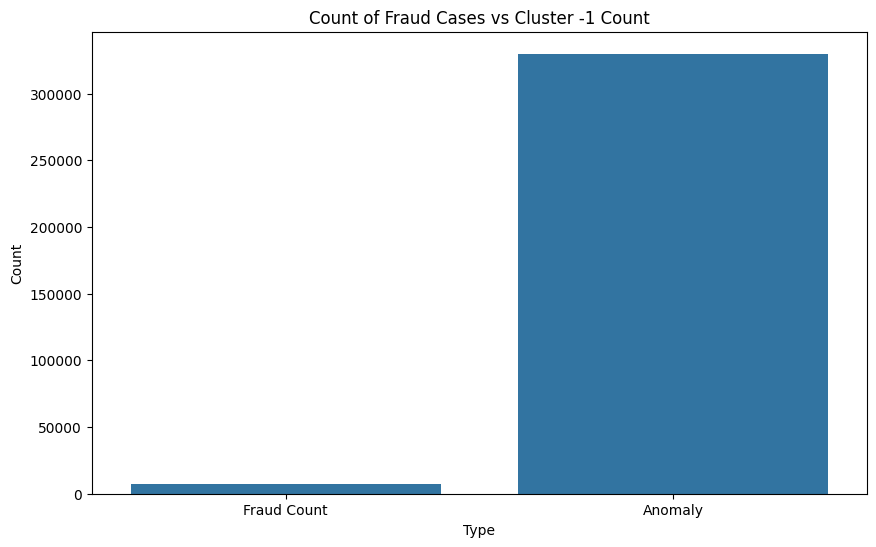

In [62]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Type', y='Count', data=fraud_counts)

# Definindo o título e os rótulos
plt.title('Count of Fraud Cases vs Cluster -1 Count')
plt.xlabel('Type')
plt.ylabel('Count')

We had a lot of anomalys probabily because our hyperparameters are wrong lets do a tunning

In [32]:
credit_df_transformed.to_csv('credit_data_with_clusters.csv', index=False)


## Tunning

## Smote Data

In my tests with tuning the DBSCAN, I encountered difficulties due to the significant class imbalance in our data. As a result, both the precision and the F1 score were poor; we were able to identify all instances of fraud, but we also misclassified many non-fraudulent cases as fraudulent, as shown in the image below. To address this issue, I decided to create a sample of the data to facilitate the testing process.

Imbalanced Data

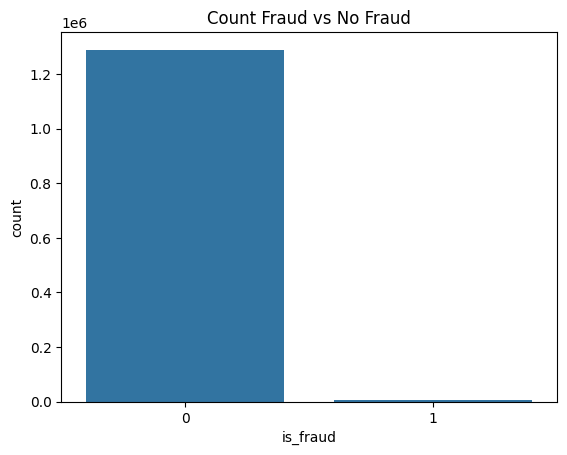


The misclassification is evident, as we have a significant number of data points that are not fraudulent included in the fraud cluster.

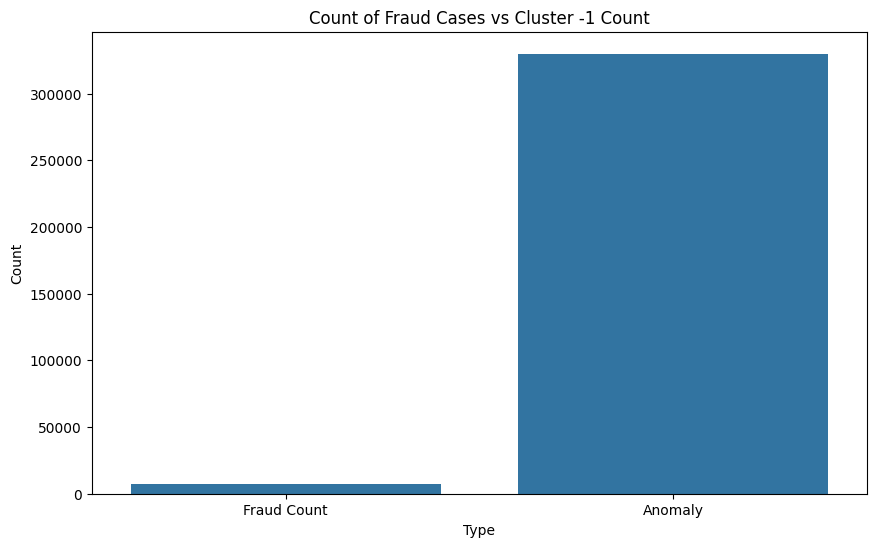

In [8]:

X = credit_df_transformed.drop('is_fraud', axis=1)
y = credit_df_transformed['is_fraud']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

credit_df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
credit_df_resampled['is_fraud'] = y_resampled

print(f'Distribuição original: {y.value_counts()}')
print(f'Distribuição após SMOTE: {y_resampled.value_counts()}')



Distribuição original: is_fraud
0    1289169
1       7506
Name: count, dtype: int64
Distribuição após SMOTE: is_fraud
0    1289169
1    1289169
Name: count, dtype: int64


## Tunning

### DBScan

In [9]:
param_grid = {
    'eps': [0.001, 0.025, 0.25, 0.5], 
    'min_samples': [5, 10, 15, 25, 35, 45, 100, 200, 400, 500],  
    'metric': ['euclidean', 'manhattan', 'chebyshev'],  
    'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],  
    'leaf_size': [30, 40, 50, 100],  
    'n_jobs': [-1]  
}


In [10]:
def evaluate_dbscan_anomalies(params, data, true_labels):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    clusters = dbscan.fit_predict(data)

    true_positive_labels = (true_labels == 1).astype(int)  
    predicted_labels = (clusters == -1).astype(int) 

    precision = precision_score(true_positive_labels, predicted_labels, zero_division=0)
    recall = recall_score(true_positive_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_positive_labels, predicted_labels, zero_division=0)

    return {'precision': precision, 'recall': recall, 'f1': f1}


In [11]:
results_anomalies = []
sample_data = credit_df_resampled.sample(n=25000, random_state=42)
for params in ParameterGrid(param_grid):
    metrics = evaluate_dbscan_anomalies(params, sample_data, sample_data['is_fraud']) 
    metrics['params'] = params
    results_anomalies.append(metrics)

results_anomalies_df = pd.DataFrame(results_anomalies)


In [12]:
best_result_anomalies = results_anomalies_df.loc[results_anomalies_df['precision'].idxmax()]
print(f"Best paramns: {best_result_anomalies['params']}")
print(f"Best F1-Score: {best_result_anomalies['f1']:.2f}")
print(f"Best recall: {best_result_anomalies['recall']:.2f}")
print(f"Best precision: {best_result_anomalies['precision']:.2f}")


Best paramns: {'algorithm': 'ball_tree', 'eps': 0.001, 'leaf_size': 30, 'metric': 'euclidean', 'min_samples': 5, 'n_jobs': -1}
Best F1-Score: 0.67
Best recall: 1.00
Best precision: 0.50


In [13]:
pca = PCA(n_components=10) 
labels = sample_data.iloc[:,-1]
sample_data_transformed = pca.fit_transform(sample_data.iloc[:, :-1])
results_anomalies = []

for params in ParameterGrid(param_grid):
    metrics = evaluate_dbscan_anomalies(params, sample_data_transformed, labels) 
    metrics['params'] = params
    results_anomalies.append(metrics)

results_anomalies_df = pd.DataFrame(results_anomalies)
best_result_anomalies = results_anomalies_df.loc[results_anomalies_df['precision'].idxmax()]

print(f"Best paramns: {best_result_anomalies['params']}")
print(f"Best F1-Score: {best_result_anomalies['f1']:.2f}")
print(f"Best recall: {best_result_anomalies['recall']:.2f}")
print(f"Best precision: {best_result_anomalies['precision']:.2f}")

Best paramns: {'algorithm': 'ball_tree', 'eps': 0.001, 'leaf_size': 30, 'metric': 'euclidean', 'min_samples': 5, 'n_jobs': -1}
Best F1-Score: 0.67
Best recall: 1.00
Best precision: 0.50


Access to recycling programs and partnerships with sustainable local suppliers can be another environmental advantage. Many cities are encouraging recycling and providing services that help small businesses, like burger joints, manage their waste more effectively. Additionally, partnering with local suppliers who use sustainable farming practices can reduce the carbon footprint and ensure responsibly sourced products. This enhances the company’s image and meets the demands of an increasingly environmentally conscious customer base.